# Phenotyping of Fly Wings

## 1. Open the Dataset and Browse the Available Features

In the folder "data" you will find the dataset used in the paper [Assessing the potential of vision language models for automated phenotyping of Drosophila melanogaster](https://www.biorxiv.org/content/biorxiv/early/2024/05/27/2024.05.27.594652.full.pdf). The dataset is composed of a XLSX file and an additional "data" folder containing the images associated with each fly wing. The first task is to:
1. open the dataset and explore it
2. examine whether any information is missing
3. using the paper, study how the dataset was created
4. find a way to open the dataset using Python

In [ ]:
# use this command to download the dataset on Google Colab:
!git clone https://github.com/fedenanni/bioimage-classification.git
!mv bioimage-classification/data ./
!rm -rf bioimage-classification 

In [6]:
# tip: feel free to use an AI tool for learning how to open the dataset in Google Colab, but you should be able to explain what the code does to load the images

import pandas as pd

df = pd.read_excel('../data/dataset.xlsx')
df.head()

,TransformantID,FlyBaseID,Original order,Random order,CGNR,Gene Symbol,Notes,Filename,Phenotype,MN,GO/IP,GO/IP Description,Expression Affi,Expression RNAs,Expression,Defect Type,Image_Path,Label
0,36466,FBgn0033164,1,17,CG11112,CG11112,NaN,CG11112.png,V-(L5),CG,NaN,NaN,5.23876,33,Y,veins (missing),data/CG11112.png,V-
1,106124,FBgn0031245,2,73,CG3625,CG3625,sal 29C,CG3625 (sal 29ºC).png,V-(w),CGh,IPR006838,FAR-17a/AIG1-like protein,3249.01000,49.6139,Y,veins (missing),data/CG3625 (sal 29ºC).png,V-
2,110723,FBgn0086680,3,20,CG10037,vvl,NaN,CG10037.png,V-,DNA,GO:0000977,RNA polymerase II regulatory region sequence-s...,1973.23000,51.8337,Y,veins (missing),data/CG10037.png,V-
3,NaN,NaN,4,45,CG3998,zf30C,sd,CG3998 (sd).png,V-,DNA,GO:0003676,nucleic acid binding,2173.12000,121.6,Y,veins (missing),data/CG3998 (sd).png,V-
4,15754,FBgn0270924,5,38,CG3998,zf30C,sd 29C,CG3998 (sd 29ºC).png,V-,DNA,GO:0003676,nucleic acid binding,2173.12000,121.6,Y,veins (missing),data/CG3998 (sd 29ºC).png,V-


In [8]:
paths = df['Image_Path'].tolist()

paths = ['../data/' + path for path in paths]


labels = df['Label'].tolist()

# Binary classification

y = [0 if label == 'wt' else 1 for label in labels]

# 2. Perform a Classification

By examining the dataset you can select a feature you want to predict based on the image. It could be, as in the paper linked above, the aberrant vs wildtype phenotye or it could be predicting generally the type of phenotype or it could be something else of your own choice. Compare the performance of two of the classified discussed in class. Be careful, in this setting you don't have many training data - are there other evaluation practices that can help you assessing performance apart from train/test split? 

In [ ]:
# tip: you need two things: 1) to convert and resize the images and 2) to select a label from the spreadsheet and use that as your y


# 3. Examine the Errors the Tools Make

Compare the errors the classifiers make (which images are mis-labelled?). Do you notice any specific type of pattern? How good are performance overall? Would you use a tool like this as part of an experimental pipeline? What would be the trade-offs?

In [13]:
# tip: you need to associate each classified image with the predicted label. Then you can manually examine a few of the errors
from PIL import Image
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
import numpy as np

X = []  # list, not numpy array yet

for path in paths:
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    X.append(np.array(image))

# Stack into one 4D tensor
X = np.stack(X)  # shape: (num_images, 224, 224, 3)

# Preprocess for ResNet
X = preprocess_input(X)

# Load pretrained ResNet (without top classifier)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract embeddings
embeddings = resnet.predict(X, verbose=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

KNN on pretrained ResNet embeddings (n_train=80, n_test=20): 0.9000

Classification Report:
              precision    recall  f1-score   support

           0      0.600     1.000     0.750         3
           1      1.000     0.882     0.938        17

    accuracy                          0.900        20
   macro avg      0.800     0.941     0.844        20
weighted avg      0.940     0.900     0.909        20



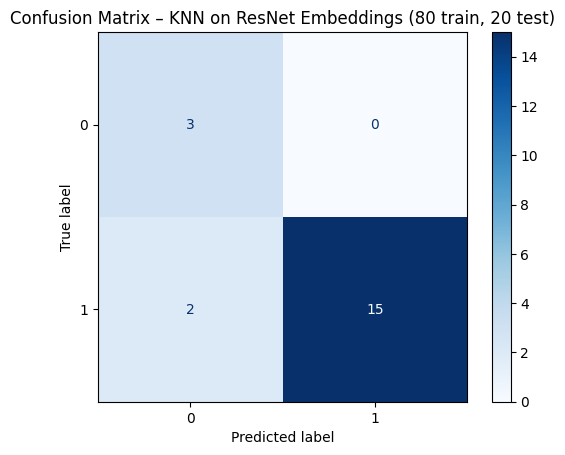

In [18]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"KNN on pretrained ResNet embeddings (n_train={len(X_train)}, n_test={len(X_test)}): {acc:.4f}")

# Precision, Recall, F1 report
report = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(2))
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix – KNN on ResNet Embeddings ({len(X_train)} train, {len(X_test)} test)")
plt.show()

# 4. Optional: LLMs for Image Classification

In the paper linked above, we used a LLM for image classification. You can try the same and then discuss what do you think are the major differences compared to training a machine learning classifier. Which benefits do you see? What are the drawbacks?

Feel free to use any LLM you want. You don't need to redo the entire classification, a specific experiment to compare performance will be good enough.